# Lyric Generator
## with data from LyricGenius API

### Authors: Jessie Yang, Ariana Lozner

------------------------------------------------------------------
#### Instructions to Run:

This notebook should run itself if you click Kernel > Restart and Run All. The only thing you have to do is make sure that the lyrics csv "taylorswift.csv" is in the same root directory as this notebook. Note: we also included some other .csvs of lyrics from different artists (also scraped from Genius API) if you're curious :)

Note that when running this, the LSTM model takes a while (~5 mins each epoch) to run. For me, it took approx. an hour to run everything, with training the LSTM model being the main bottleneck. We've provided a PDF of the output of this notebook for you to look at if you don't want to run it. 

Also, you are welcome to change the number of hidden units/epochs for each neural network, but I noticed a plateau after the given number of epochs. 

------------------------------------------------------------------

#### Notes:

##### Model -
1. Statistical BOW Model -- bigram, no smoothing
2. Feed-Forward Neural Network with word2vec bigram embeddings -- 1 layer with 150 hidden units, 10 epochs
3. a. LSTM Neural Network with word2vec bigram embeddings -- 1 layer with 50 hidden units, 0.2 dropout, 5 epochs
   b. LSTM Neural Network with variable-sized ngrams -- 1 layer with 50 hidden units, 0.2 dropout, 15 epochs

##### Data -
All Taylor Swift lyrics split in bigram sequences. Lyrics do not include anything not in english or anything that is not a song (i.e.: voice memos or interviews). Lyrics come from the given .csv, which was populated using the LyricGenius API and hand-edited to remove non-english entries and non-song entries. 

Note: for Model 3.b., the data is split slightly differently (we were following a tutorial). It is split into variable-sized ngrams for each line of the song.

##### Results -
Roughly 30% accuracy from both NN models and slightly higher for the statistical model.

In [5]:
import pandas as pd
import numpy as np
from nltk import word_tokenize, ngrams
import contractions
from keras.preprocessing.text import Tokenizer
import keras.utils.np_utils as ku
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random

In [6]:
# misc global vars
NGRAM_SIZE = 2 # note: we chose bigrams since the corpus is relatively small 
               # and higher-order ngrams are more often used for large (>1mil) corpora
LINE_START = '<s>'
LINE_END = '</s>'

# embedding size note: this can be changed to whatever
# we're using 100 to make the runtime less long
EMBEDDINGS_SIZE = 100

# Data Extraction

In [7]:
def csv_to_lst(file):
    """
    Grabs the lyric section of the given csv and convert it to a string
    Parameters:
        file (CSV): file path where csv is located
    Returns:
        A list string representing all of the text section in the csv
    """
    lyrics_df = pd.read_csv(file) 

    lyrics_list = list(lyrics_df['lyrics'])

    return lyrics_list

In [8]:
def pre_process_all_lyrics(lyric_list):
    '''
    Runs preprocessing algorithm over all lyrics.
    Parameters:
    lyric_list -- list of strings representing a list of songs
    '''
    processed = []
    for lyrics in lyric_list:
#         print(lyrics)
        processed.append(pre_process_text(lyrics))
    return processed

In [11]:
def pre_process_line(line):
    '''
    Processes a line in a song by: tokenizing words, removing punctuation, removing header, removing anything in brackets
    (meta data), removing embed tag at the end of each song (LyricGenius API quirk), adds line-start and line-end markers
    Parameters:
    line - a string representing a line in a song
    '''
    EMBED = 'embed'
    word_list = word_tokenize(line)
    
    no_brackets_list = []
    is_inside = False
    punctuation_list = '''!()-[];:'"\,<>./?@#$%^&*_~”“’‘--...``'''''
    
    for word in word_list:
        if word == '[':
            is_inside = True
        if word == ']':
            is_inside = False
        else:
            if not is_inside:
                if word not in punctuation_list:
                    no_brackets_list.append(word.lower())

    if len(no_brackets_list) > 0:
        end_word = no_brackets_list[len(no_brackets_list)-1]   
        if EMBED in end_word:
#             print(end_word)
            embed_location = end_word.index('embed') 
            # all lyric genius data comes with word 'Embed' at the end
            substr = end_word[:embed_location]
            if len(substr) > 0:
                no_brackets_list[len(no_brackets_list)-1] = substr
        
        end_word = no_brackets_list[len(no_brackets_list)-1]  
        new_end_word = ''
        # also sometimes has a number before embed in last word
        for c in end_word:
            if c.isdigit():
                break
            else:
                new_end_word = new_end_word + c
        if len(end_word) > 0:
            no_brackets_list[len(no_brackets_list)-1] = new_end_word
       
    #note: we are doing this so that when we try to generate full song lyrics later, we have a marker to decide when
    # to move on to the next line
    ret = [LINE_START]
    for word in no_brackets_list:
        if len(word) < 0:
            break
        #idk why this is like this 
        elif word == "''":
            break
        else:
            ret.append(word)
            
    ret.append(LINE_END)
    return ret

In [12]:
def pre_process_text(lyrics):
    """
    Removes contractions, splits song lyrics into lines to be processed by pre_process_lin
    Parameters:
        lyrics (list): list of song lyrics
    Returns:
        List of List of words with start and end tokens
    """
    
    lyrics = contractions.fix(lyrics)
    line_list = lyrics.split("\n")
    line_list = line_list[1:] # removes the first line which contains meta info line artist name/song title etc
    
    ret = []
    for line in line_list:
        if not len(line) == 0:
            to_be_appended = pre_process_line(line)
            if len(to_be_appended) > 0:
                ret.append(to_be_appended)
    return ret

In [14]:
def flatten_songs(triple_list):
    """
    Optional: flattens list of [songs[lines[words]]] (3 deep) to just one
    long list of lines. This is used to make word vectors more smoothly
    Parameters:
        triple_list (list): list of lyrics 
    Returns:
        List of List of words with start and end tokens
    """
    long_list_lines = []
    for song in triple_list:
        for line in song:
            long_list_lines.append(line)
    return long_list_lines

In [18]:
lst = csv_to_lst('taylorswift.csv')
 
all_songs = pre_process_all_lyrics(lst)
all_songs = flatten_songs(all_songs)


In [20]:
print(all_songs[:50])

[['<s>', 'i', 'walked', 'through', 'the', 'door', 'with', 'you', 'the', 'air', 'was', 'cold', '</s>'], ['<s>', 'but', 'something', "'bout", 'it', 'felt', 'like', 'home', 'somehow', '</s>'], ['<s>', 'and', 'i', 'left', 'my', 'scarf', 'there', 'at', 'your', 'sister', "'s", 'house', '</s>'], ['<s>', 'and', 'you', 'have', 'still', 'got', 'it', 'in', 'your', 'drawer', 'even', 'now', '</s>'], ['<s>', '</s>'], ['<s>', 'oh', 'your', 'sweet', 'disposition', 'and', 'my', 'wide-eyed', 'gaze', '</s>'], ['<s>', 'we', 'are', 'singin', 'in', 'the', 'car', 'getting', 'lost', 'upstate', '</s>'], ['<s>', 'autumn', 'leaves', 'fallin', 'down', 'like', 'pieces', 'into', 'place', '</s>'], ['<s>', 'and', 'i', 'can', 'picture', 'it', 'after', 'all', 'these', 'days', '</s>'], ['<s>', '</s>'], ['<s>', 'and', 'i', 'know', 'it', 'is', 'long', 'gone', 'and', '</s>'], ['<s>', 'that', 'magic', "'s", 'not', 'here', 'no', 'more', '</s>'], ['<s>', 'and', 'i', 'might', 'be', 'okay', 'but', 'i', 'am', 'not', 'fine', 'at'

# word2vec

In [21]:
# pip install gensim

In [22]:
def train_word2vec(word_matrix):
    """
    Trains a Word2Vec model on the corpus provided
    Parameters:
        word_matrix: a list of list of string representing words in sentences in 
                    a larger corpus
                    eg:
                    [["<s>", "this", "is", "an", "example", "</s>"],
                     ["<s>", "this", "is", "also", "</s>"]
                    ]
    Returns:
        the trained Word2Vec model
    """
    model = Word2Vec(sentences=word_matrix, vector_size= EMBEDDINGS_SIZE, window=5,min_count=1)
    print('Vocab size {}'.format(len(model.wv.index_to_key)))
    return model

In [23]:
w2v_model = train_word2vec(all_songs)
word_vectors = w2v_model.wv

Vocab size 4887


## Data Visualization Segue

I was curious to see if there was any relation of lyrics between albums. 

In [24]:
# save as keyed vector for easy use
word_vectors.save('taylor_swift_wv.kv')

In [25]:
word_kv = KeyedVectors.load('taylor_swift_wv.kv')

print('50 most commonly words:')
print(word_kv.index_to_key[:50])

50 most commonly words:
['<s>', '</s>', 'i', 'you', 'the', 'and', 'to', 'is', 'it', 'me', 'not', 'a', 'my', 'in', 'that', 'are', 'your', 'do', 'of', 'we', 'all', 'am', 'but', 'on', 'will', 'was', 'be', 'know', 'like', 'have', 'this', 'oh', 'so', 'when', 'just', 'can', 'would', 'there', 'for', 'never', 'love', 'now', 'what', 'time', 'with', 'because', 'up', 'want', 'at', 'he']


### Graphing
Adapted from HW4

In [28]:
graph_alpha = 0.7
n_similar_words = 30

In [29]:
def embedding_clusters(keys, kv, top_n_most_similar):
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embeddings = []
        words = []
        for similar_word, _ in kv.most_similar(word, topn=top_n_most_similar):
            words.append(similar_word)
            embeddings.append(kv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    return (word_clusters, embedding_clusters)

In [30]:
def embeddings_en_2d(embedding_clusters):
    embedding_clusters_np = np.array(embedding_clusters)
    n, m, k = embedding_clusters_np.shape
    tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters_np.reshape(n * m, k))).reshape(n, m, 2)
    return embeddings_en_2d

In [31]:
# plotting stuff 
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [32]:
def plot_similarities(title, labels, kv, n_similar_words, a, filename):
    '''plots similar words to the given labels
    Parameters:
    title -- title of the graph
    labels -- list of words to find similar words to
    kv -- keyed vectors to use aka whole dataset
    n_similar_words -- number of similar words to find
    a -- alpha value for graph
    filename -- what to save the file as
    '''
    
    cluster = embedding_clusters(labels, kv, n_similar_words)
    en_2d = embeddings_en_2d(cluster[1])
    
    tsne_plot_similar_words(title, labels, en_2d, cluster[0], a, filename)

### by album name

In [33]:
# not an exhaustive list, just the main ones
# tragically speak now had to split into two words, which is not necessarily scientifically sound, but this is just
# supplementary work anyways -- I didn't want to spend too much time on it
album_titles = ['speak', 'now', 'fearless', 
                'red', '1989', 'reputation', 
                'lover', 'folklore', 'evermore']

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

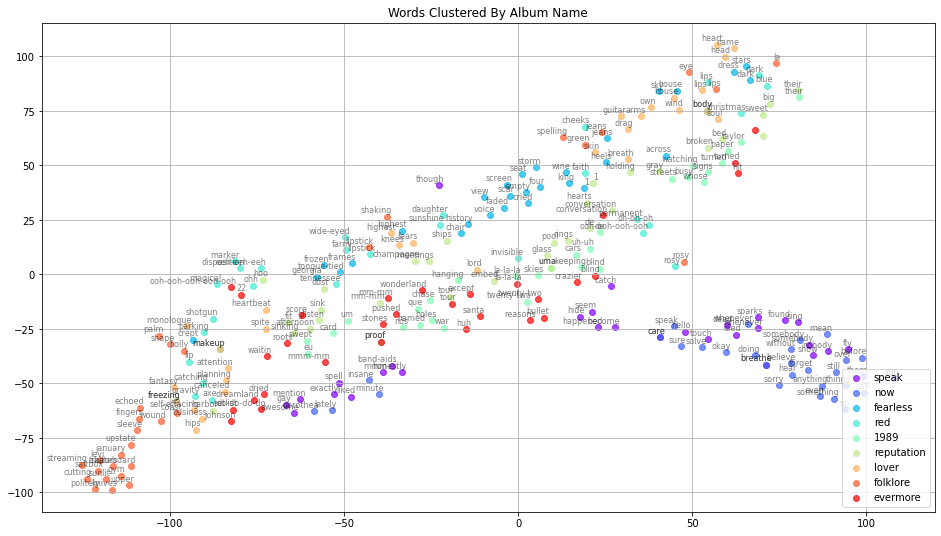

In [34]:
plot_similarities('Words Clustered By Album Name',
                 album_titles,
                 word_kv,
                 n_similar_words,
                 graph_alpha,
                 'taylor_swift_words_cluster_by_album.png')

Not as clustered as I'd hoped :( but also not unclustered :)

### by pronoun

was also interested in pronouns

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

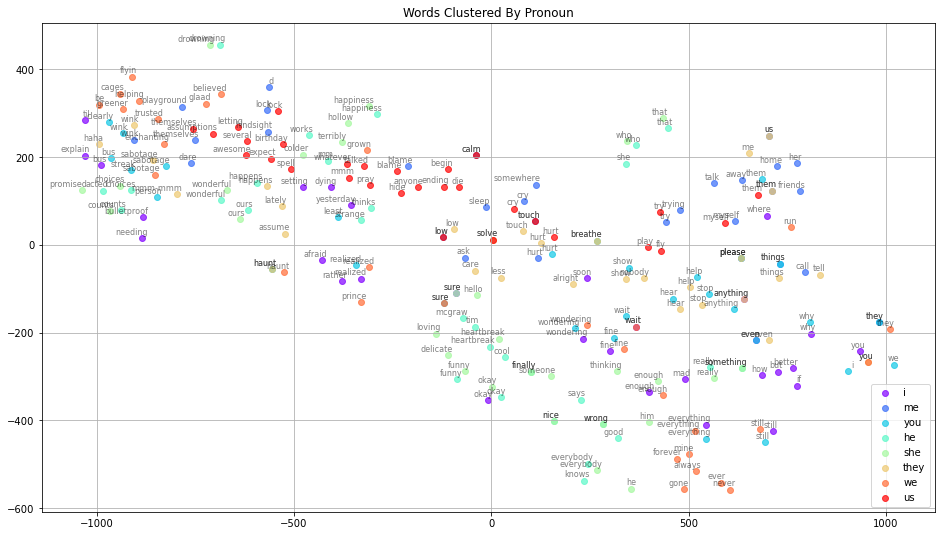

In [35]:
pronouns = ['i', 'me', 'you', 'he', 'she', 'they', 'we', 'us']

plot_similarities('Words Clustered By Pronoun',
                 pronouns,
                 word_kv,
                 n_similar_words,
                 graph_alpha,
                 'taylor_swift_words_cluster_by_pronoun.png')

### by posessive pronoun

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

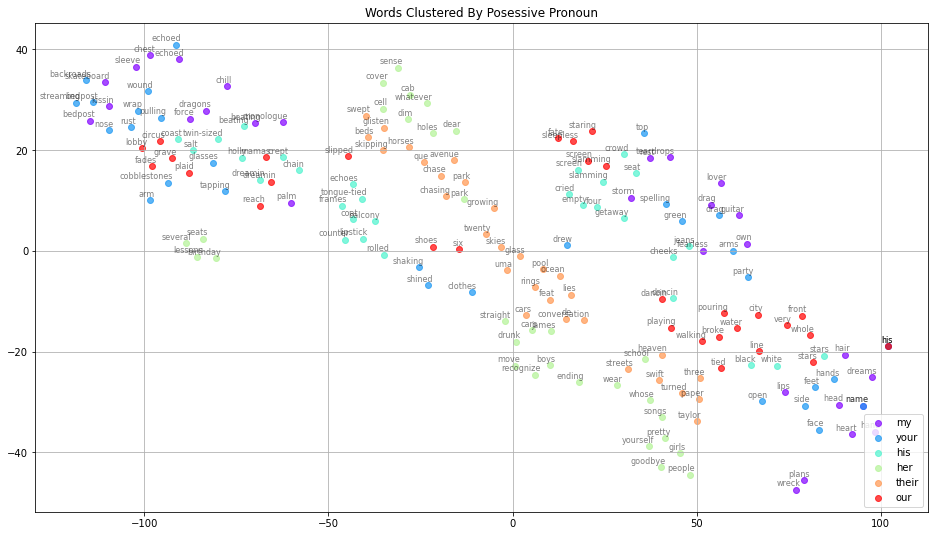

In [36]:
posessive_pronouns = ['my', 'your', 'his', 'her', 'their', 'our']

plot_similarities('Words Clustered By Posessive Pronoun',
                 posessive_pronouns,
                 word_kv,
                 n_similar_words,
                 graph_alpha,
                 'taylor_swift_words_cluster_by_posessive_pronoun.png')

# Generate Training Samples
Also adapted from HW4

In [220]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(all_songs)
sequences = tokenizer.texts_to_sequences(all_songs)
# print(flatten_genre[0:10])
# print(word_embeddings[0:10])
print('corpus len: ', len(sequences))
# to_categorical needs this idk why
# vocab_size = len(tokenizer.word_index) + 1
# print('vocab size: ', vocab_size)

corpus len:  25867


### split into ngrams

In [221]:
def generate_ngram_training_samples(word_embeddings, n) -> list:
    '''
    Takes the encoded data (list of lists) and 
    generates the training samples out of it.
    Parameters:
    word embeddings = list
    n = size of n gram
    return: 
    list of lists in the format [[x1, x2, ... , x(n-1), y], ...]
    '''
    full_list = []
    for we in word_embeddings:
        full_list.extend(we)
    ngram_list_tup = ngrams(full_list, n)
    ngram_list = []
    for tup in ngram_list_tup:
        as_list = list(tup)
        ngram_list.append(as_list)
    return ngram_list

In [222]:
ngrams_list = generate_ngram_training_samples(sequences, NGRAM_SIZE)
# print(ngrams_list[:10])
print('num ngrams: ', len(ngrams_list))
# print(ngrams_list)

num ngrams:  221790


In [223]:
def get_X_y(ngrams_list):
    '''
    Splits n-grams into X predictor matrix and associated y label vector
    Parameters:
    ngrams_list = list of ngrams in form of [[0, 1], [1, 2] ....]
    return: 
    tuple (X, y)
    '''
    X = []
    y = []
    # splits ngrams into [a, b], [c]
    for ng in ngrams_list:
        x = []
        for i in range(0, len(ng)):
            if i < len(ng) - 1:
                #predictor
                x.append(ng[i])
            else:
                #label
                y.append(ng[i])
        X.append(x)
    # note both need to be np.arrays to work with model
    return (np.array(X), np.array(y))

In [224]:
X_pred, y_label = get_X_y(ngrams_list)

# spot check for correctness
# for i in range(0, 10):
#     print(X_pred[i], y_label[i])
print('X shape: ', X_pred.shape)
print('y shape: ', y_label.shape)

# print('y indexed at ?')
# copy = np.sort(y_label.copy())
# print(type(copy))
# print(copy[:10])
# print(copy[len(copy)-10:])

X shape:  (221790, 1)
y shape:  (221790,)


In [225]:
def map_sequences_to_embeddings(word_vectors, tokenizer):
    '''maps word's sequence to word's embedding
    Parameters:
        word_vectors word vector list from word2vec
        tokenizer the tokenizer trained on the corpus
    Returns:
        dict mapping the word's sequence (from tokenizer) to it's embedding
    '''
    seq_to_embedding = dict()
    for word in word_vectors.index_to_key:
        embedding = word_vectors[word]
        seq = tokenizer.word_index[word]
        seq_to_embedding[seq] = embedding
    
    print('seq to embeddings map size: ', len(seq_to_embedding.keys()))
    
    return seq_to_embedding

In [226]:
seq_to_embedding_map = map_sequences_to_embeddings(word_vectors, tokenizer)
vocab_size = len(seq_to_embedding_map.keys())

seq to embeddings map size:  4887


### change bigrams to embeddings for model

In [227]:
def to_embeddings(X: list, y: list, sequence_embeddings: dict) -> (list,list):
    '''
    turns X sequences and y sequences to embeddings
    Parameters:
        X - list of ngram sequences that are the predictors
        y - list of sequences that are the associated labels
        sequence_embeddings - maps sequences to w2v embeddings
    Returns:
        a tuple of (X_as_embeddings, y_as_embeddings)
    '''
    vocab_size = len(sequence_embeddings.keys())
    
    if len(X) != len(y):
        print('error: something went wrong here -- X should be same len as y')
    
    X_embeddings = []
    for ngram in X:
        embedding = []
        for gram in ngram:
            embedding.extend(sequence_embeddings[gram])
        X_embeddings.append(embedding)
    
    # use to_categorial to get one_hots
    y_categorical_labels = ku.to_categorical(y) 
    
    return (np.array(X_embeddings), y_categorical_labels)

In [228]:
# pred and label initial inputs
X_embedding_matrix, y_categorical_label = to_embeddings(X_pred,
                                                         y_label,
                                                         seq_to_embedding_map)

# spot check
print('x embeddings shape: ', X_embedding_matrix.shape)
print('y label shape: ', y_categorical_label.shape)

x embeddings shape:  (221790, 100)
y label shape:  (221790, 4888)


# Create Models

### Baseline Statistical Model - Bigram Bag of Words
We're doing this to see if using a Neural Network at all is overkill, since this corpus is relatively small. Code is adapted from HW2. Uses the raw bigrams as opposed to embeddings. Does not apply laplace smoothing.

In [231]:
class Bigram_BOW_Model:
    def __init__(self, tokenizer, sequences):
        training_data, testing_data = self.split_dataset(sequences)
        training_bigrams = generate_ngram_training_samples(training_data, 2)
        testing_bigrams = generate_ngram_training_samples(testing_data, 2)
        
        self.vocab_size = len(tokenizer.word_index) + 1
    
        bigram_matrix = self.bigram2matrix(training_bigrams)
        
        flattened = np.concatenate(sequences)
        word2count = Counter(flattened)
        self.word2probability = self.calc_probability(bigram_matrix, 
                                                          word2count)
        self.accuracy = self.test_accuracy(testing_bigrams)
        
        self.summary()
        pass
    
    def split_dataset(self, sequences):
        '''
        reserves a random subset of the corpus for testing purposes. subset reserved is 10%
        '''
        n_reserve = int(0.1 * len(sequences))
        reserve = []
        for _ in range(1, n_reserve):
            rand = random.randint(0, len(sequences) - 1)
            test_datum = sequences[rand]
            reserve.append(test_datum)
            del(sequences[rand])
        
        return (sequences, reserve)
    
    def bigram2matrix(self, bigrams):
        ''' creates a vocab_size*vocab_size matrix that counts the number
        of times that a sequence appears after another sequence in the list
        of ngrams
        '''
        M = np.zeros(shape=(self.vocab_size, self.vocab_size))
        for pair in bigrams:
#             print(pair)
            w1 = pair[0]
            w2 = pair[1]
            M[w1][w2] += 1.0
        return M
    
    def calc_probability(self, bigram_matrix, word2count):
        ''' creates a vocab_size*vocab_size matrix that tells the probability that
        row sequence will be followed by col sequence.
        '''   
        M = np.zeros(shape=(self.vocab_size, self.vocab_size))
        for row in range(1, self.vocab_size):
            for col in range(1, self.vocab_size):
                M[row][col] = bigram_matrix[row][col] / (word2count[row])
        return M
    
    def test_accuracy(self, testing_bigrams):
        ''' tests the given gold-label test set against what the model predicts
        '''
        correct_count = 0
        
        for datum in testing_bigrams:
            pred = datum[0]
            label = datum[1]
            
            pdistr = self.predict(pred)[0]
            choice = np.argmax(pdistr)
            if choice == label:
                correct_count += 1
        return float(correct_count) / float(len(testing_bigrams))
    
    def predict(self, seed):
        ''' returns probability matrix of the given seed sequence
        '''
        return [self.word2probability[seed]]
    
    def summary(self):
        print("------------------------------")
        print("BIGRAM BOW STATISTICAL MODEL:")
        print("------------------------------")
        print("accuracy: ", self.accuracy)
        print("------------------------------")

In [232]:
# train statistical model
bow_model = Bigram_BOW_Model(tokenizer, sequences)

/var/folders/92/hkn2b2hd6vlf9bf_51zhtkkc0000gn/T/ipykernel_47843/1393676179.py:54: RuntimeWarning: invalid value encountered in double_scalars
  M[row][col] = bigram_matrix[row][col] / (word2count[row])


------------------------------
BIGRAM BOW STATISTICAL MODEL:
------------------------------
accuracy:  0.33601977750309026
------------------------------


### Feed-Forward Neural Network
2-layer model with 200 hidden units per each layer. Works on bigram word vectors

In [131]:
def create_FF_model(pred,
                 label,
                 hidden_units,
                 vocab_size, 
                 num_epochs):
    '''
    Creates a model using a 1-layer Feedforward neural network
    '''
    model = Sequential()
    model.add(Dense(units=hidden_units, 
                    activation='relu', 
                    input_dim=pred.shape[1]))
    model.add(Dense(units=hidden_units))
    
    # output layer
    model.add(Dense(units=vocab_size, 
                    activation='softmax'))
    
    # compile and fit
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    
    model.fit(x=pred, 
                     y=label,
                     epochs=num_epochs)
    print(model.summary())
    
    return model

In [132]:
hidden_units = 200
# plateaus after this
num_epochs = 10
ff_model = create_FF_model(X_embedding_matrix,
                           y_categorical_label,
                           hidden_units,
                           vocab_size + 1,
                           num_epochs)

Epoch 1/10
6931/6931 [==============================] - 50s 7ms/step - loss: 4.1069 - accuracy: 0.2855
Epoch 2/10
6931/6931 [==============================] - 49s 7ms/step - loss: 3.8100 - accuracy: 0.2943
Epoch 3/10
6931/6931 [==============================] - 49s 7ms/step - loss: 3.7188 - accuracy: 0.2969
Epoch 4/10
6931/6931 [==============================] - 47s 7ms/step - loss: 3.6640 - accuracy: 0.2983
Epoch 5/10
6931/6931 [==============================] - 48s 7ms/step - loss: 3.6241 - accuracy: 0.3001
Epoch 6/10
6931/6931 [==============================] - 50s 7ms/step - loss: 3.5935 - accuracy: 0.3020
Epoch 7/10
6931/6931 [==============================] - 48s 7ms/step - loss: 3.5702 - accuracy: 0.3018
Epoch 8/10
6931/6931 [==============================] - 48s 7ms/step - loss: 3.5476 - accuracy: 0.3041
Epoch 9/10
6931/6931 [==============================] - 50s 7ms/step - loss: 3.5306 - accuracy: 0.3051
Epoch 10/10
6931/6931 [==============================] - 51s 7ms/step - l

### LSTM Neural Network

#### using on bigrams word vectors
1-layer model with 50 hidden units per each layer (this is less than the feed-forward network because we found it doesn't really help to have more and also takes forever to train.

In [133]:
def create_LSTM_model(pred,
                     label,
                     hidden_units,
                     vocab_size,
                     num_epochs):
    '''
    Creates a model using a 1-layer LSTM neural network
    note: 50 hidden units for each layer
    '''
    #lstm expects input in the shape of (# samples, #timesteps, #features)
    # we're using one feature per input 
    pred = pred.reshape((pred.shape[0], pred.shape[1], 1))
    
    model = Sequential()
    
    model.add(LSTM(hidden_units, 
                   activation='relu',
                   input_shape=(pred.shape[1], 1),
#                    return_sequences=True
                  ))
    model.add(Dropout(0.2))
#     model.add(LSTM(50, 
#                    activation='relu'
#                   ))
    
    # output layer
    model.add(Dense(units=vocab_size, 
                    activation='softmax'))
    
    # compile and fit
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    model.fit(x=pred, 
                     y=label,
                     epochs=num_epochs)
    
    print(model.summary())
    return model

In [134]:
#spot check
print(X_embedding_matrix.shape)
print(X_embedding_matrix[0].shape)
print(X_embedding_matrix.shape[1])
print(len(X_embedding_matrix[0]))

(221790, 100)
(100,)
100
100


In [136]:
# kinda plateau's after that
hidden_units = 50
num_epochs = 5
lstm_model = create_LSTM_model(X_embedding_matrix,
                            y_categorical_label,
                            hidden_units,
                            vocab_size + 1,
                            num_epochs)

Epoch 1/5
6931/6931 [==============================] - 176s 25ms/step - loss: 1028.4397 - accuracy: 0.1257
Epoch 2/5
6931/6931 [==============================] - 173s 25ms/step - loss: 5.1695 - accuracy: 0.1601
Epoch 3/5
6931/6931 [==============================] - 174s 25ms/step - loss: 4.9708 - accuracy: 0.1814
Epoch 4/5
6931/6931 [==============================] - 180s 26ms/step - loss: 4.9453 - accuracy: 0.1800
Epoch 5/5
6931/6931 [==============================] - 182s 26ms/step - loss: 22.1542 - accuracy: 0.1732
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_19 (Dense)            (None, 4888)              24

#### using on variable-sized ngrams 
We found a tutorial online for text generation with LSTM and it broke it's data up by line, so we thought we would try that as well.

Source: https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275

but first, we had to change our data slightly -- instead of using pre-trained word vector embeddings, we will feed the model the raw sequences and let it embed them itself. These raw sequences are formatted as lines instead of bigrams

In [137]:
def stringify_lines(data):
    corpus = []
    for line in data:
        line_string = ""
        for word in line: 
            line_string = line_string + ' ' + word
        corpus.append(line_string)
    return corpus

In [138]:
def dataset_preparation(tokenizer, data):
    corpus = stringify_lines(data)
    print('sample of what the new data shape looks like:')
    print(corpus[:10])
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1

#     print('tokenization:')
#     print(tokenizer.word_index)
    # create input sequences using list of tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

#     print('input_sequences:')
#     print(input_sequences)
    # pad sequences 
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

#     print('padded input_sequences:')
#     print(input_sequences)
    # create predictors and label
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    
#     print('X predictors:')
#     print(predictors)
#     print('y labels:')
#     print(label)
    label = ku.to_categorical(label, num_classes=total_words)
    
    return predictors, label, max_sequence_len, total_words

In [139]:
def create_LSTM_model_variable_size(predictors, label, max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    model.add(Embedding(total_words, EMBEDDINGS_SIZE, input_length=input_len))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(predictors, label, epochs=15, verbose=1)
    
    print(model.summary())
    return model

In [140]:
tokenizer2 = Tokenizer()
predictors, label, max_sequence_len, total_words = dataset_preparation(tokenizer2, all_songs)

lstm_var_size_model = create_LSTM_model_variable_size(predictors, label, max_sequence_len, total_words)

sample of what the new data shape looks like:
[' <s> i walked through the door with you the air was cold </s>', " <s> but something 'bout it felt like home somehow </s>", " <s> and i left my scarf there at your sister 's house </s>", ' <s> and you have still got it in your drawer even now </s>', ' <s> </s>', ' <s> oh your sweet disposition and my wide-eyed gaze </s>', ' <s> we are singin in the car getting lost upstate </s>', ' <s> autumn leaves fallin down like pieces into place </s>', ' <s> and i can picture it after all these days </s>', ' <s> </s>']
Epoch 1/15
6171/6171 [==============================] - 139s 22ms/step - loss: 5.0279 - accuracy: 0.1722
Epoch 2/15
6171/6171 [==============================] - 137s 22ms/step - loss: 4.3113 - accuracy: 0.2348
Epoch 3/15
6171/6171 [==============================] - 131s 21ms/step - loss: 3.9860 - accuracy: 0.2639
Epoch 4/15
6171/6171 [==============================] - 128s 21ms/step - loss: 3.7518 - accuracy: 0.2884
Epoch 5/15
6171/6171

# generate lyrics

In [146]:
def get_seed_embeddings(sequence_list, seq_to_embeddings_map, ngram_size):
    '''from the list of seed sequences, maps them to their embeddings. 
    ensures that the embedding is ngram len.
    NOTE: if there is no embedding for the given sequence, it will just return something random
    '''
    pred_size = ngram_size - 1
    if len(sequence_list) > pred_size:
        sequence_list = sequence_list[len(sequence_list) - pred_size:]
    embedding_list = []
    for seq in sequence_list:
        embedding_list.extend(seq_to_embeddings_map[seq])

    return np.array(embedding_list)
            

In [175]:
def generate_bigram_text(tokenizer, 
                  model, 
                  seq_to_embedding_map, 
                  seed_text, 
                  num_lines_to_generate, 
                  ngram_size, 
                  useEmbedding
                 ):
    words = []
    # start off return set of words with the seed
    words.extend(seed_text.split())
    lines_generated_counter = 0
    
    while lines_generated_counter < num_lines_to_generate:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        if len(token_list) == 0:
            # invalid seed/seed doesn't exist in corpus -- choose a random one
            random_seq = np.random.choice(np.arange(1, len(seq_to_embedding_map.keys())))
            token_list = [random_seq]
        
        embeddings = get_seed_embeddings(token_list, seq_to_embedding_map, ngram_size)
        
        #basically are we using embeddings or not -- both fixed-size ngram NNs do, BOW and var-size LSTM doesn't
        if useEmbedding:
            predicted = model.predict(np.reshape(embeddings, (-1, embeddings.shape[0])), verbose=0)
        else:
            token_list = token_list[0]
            predicted = model.predict(token_list)
            

        # ways of getting the top choice -- either is fine but we like np.random.choice the best
        
#         choice = np.argmax(predicted)
        choice = np.random.choice(len(predicted[0]), p=predicted[0]) 

        word = tokenizer.index_word[choice]
        
        # so we stop eventually
        if word == LINE_END:
            lines_generated_counter += 1
        
        words.append(word)
#         print(word)
        seed_text = word # this is fine because we're running a bigram
        
    return format_lyrics(words)

In [205]:
def generate_ngram_text(tokenizer, model, seed_text, num_lines_to_generate, max_sequence_len):
    words = []
    words.extend(seed_text.split())
    lines_generated_counter = 0
    while lines_generated_counter < num_lines_to_generate:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        
#         choice = np.argmax(predicted)
        choice = np.random.choice(len(predicted[0]), p=predicted[0])
    
        word = tokenizer.index_word[choice]
        print(repr(word))
        words.append(word)
        if word == LINE_END or len(words) % max_sequence_len == 0: # new line time
            print('RET')
            lines_generated_counter += 1
            seed_text = word
        else:
            seed_text = seed_text + " " + word
#         seed_text = word
#         output_word = ""
#         for word, index in tokenizer.word_index.items():
#             if index == predicted[0]:
#                 output_word = word
#                 break
#         seed_text += " " + output_word
    return format_lyrics(words)

In [213]:
def format_lyrics(words):
    lyr = ""
    print(repr(LINE_END))
    print(repr(LINE_START))
    for word in words:
        if word == LINE_END or word == 's':
            # replace with newline char
            lyr = lyr + "\n"
        else: 
            # add lyric
            if word != LINE_START and word != 's':
                lyr = lyr + " " + word
    return lyr

# Compare Results
Compares the resulting lyrics generated by each model using the same seed

In [207]:
def generate_lyrics(seed, 
                    useBOW, 
                    useFF, 
                    useLSTM,
                    useLSTMvarsize,        
                    n_lines):
    '''Generates lyrics using the same seed and same number of lines for each model.
    Parameters:
    useBOW -- boolean flag for if we should use BOW model
    useFF -- boolean flag for if we should use FF model
    useLSTM -- boolean flag for if we should use LSTM model
    useLSTMvarsize -- boolean flag for if we should use variable size LSTM model
    seed -- seed text i.e.: 'i'
    n_lines -- number of lines to generate
    
    '''
    print('+++++++++++++++++++++++++++++++++++++++++++++++++')
    print('Seed: ', seed)
    print('Num. Lines: ', n_lines)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++')
    
    if useBOW:
        lyrics = generate_bigram_text(tokenizer, 
                          bow_model,
                          seq_to_embedding_map,
                          seed, 
                          n_lines, 
                          NGRAM_SIZE,
                          False)
        print('==============================================')
        print('Model Info: Laplace-Smoothed Bigram BOW Statistical Model')
        print('----------------------')
        print(lyrics)
        print('==============================================')
    
    if useFF:
        lyrics = generate_bigram_text(tokenizer, 
                          ff_model,
                          seq_to_embedding_map,
                          seed, 
                          n_lines, 
                          NGRAM_SIZE,
                          True)
        print('==============================================')
        print('Model Info: Feed-Forward Neural Network -- Word Embeddings')
        print('----------------------')
        print(lyrics)
        print('==============================================')
    if useLSTM:
        lyrics = generate_bigram_text(tokenizer, 
                          lstm_model,
                          seq_to_embedding_map,
                          seed, 
                          n_lines, 
                          NGRAM_SIZE,
                          True)
        print('==============================================')
        print('Model Info: LSTM Neural Network -- Word Embeddings')
        print('----------------------')
        print(lyrics)
        print('==============================================')
        
    if useLSTMvarsize:
        lyrics = generate_ngram_text(tokenizer2, 
                          lstm_var_size_model,
                          seed, 
                          n_lines, 
                          max_sequence_len)
        print('==============================================')
        print('Model Info: LSTM Neural Network -- Variable-Sized NGram Sequences')
        print('----------------------')
        print(lyrics)
        print('==============================================')
    print('Done.')

# Finally, some lyrics!

In [208]:
lines_to_generate = 5

In [233]:
generate_lyrics('you are', True, True, True, True, lines_to_generate)

+++++++++++++++++++++++++++++++++++++++++++++++++
Seed:  you are
Num. Lines:  5
+++++++++++++++++++++++++++++++++++++++++++++++++
'</s>'
'<s>'
Model Info: Laplace-Smoothed Bigram BOW Statistical Model
----------------------
 you are carried me a fearless
 too soon
 a pastry
 eve
 too far to be messed with you made me twice 'fore you

Done.


In [214]:
generate_lyrics('i am', False, False, False, True, lines_to_generate)

+++++++++++++++++++++++++++++++++++++++++++++++++
Seed:  i am
Num. Lines:  5
+++++++++++++++++++++++++++++++++++++++++++++++++
'so'
'right'
'in'
'you'
'but'
'you'
'will'
'get'
'here'
'for'
'me'
's'
'you'
'will'
'be'
'alright'
'hey'
'hey'
'yeah'
's'
's'
's'
's'
'turning'
'it'
'easy'
's'
'the'
'same'
's'
's'
'i'
'was'
'riding'
'on'
'the'
'side'
'than'
'we'
's'
's'
's'
'we'
'run'
'away'
'the'
'clear'
'yet'
RET
'must'
'have'
'to'
'be'
'alone'
'because'
'i'
'do'
'not'
'know'
'what'
'you'
'are'
'yet'
'in'
'my'
'hand'
's'
'me'
's'
'a'
'hardwood'
'girls'
'take'
'trying'
's'
's'
'and'
'you'
'are'
'just'
's'
'of'
'me'
's'
's'
's'
'you'
'and'
'you'
'let'
'me'
'again'
's'
'me'
's'
's'
's'
'passed'
's'
RET
'and'
'shame'
'on'
'our'
'feet'
'down'
's'
'way'
'it'
's'
's'
's'
'standing'
'here'
'out'
'of'
'dear'
'and'
'we'
'run'
'and'
'oh'
's'
'it'
'turn'
's'
'oh'
'no'
'one'
's'
's'
'my'
'point'
'of'
'going'
's'
's'
'i'
'was'
'mmm'
's'
's'
'i'
's'
's'
'it'
's'
's'
'summer'
'smile'
RET
'and'
'now'
'we'
'w

In [203]:
# generate_lyrics('this is', True, True, True, True, lines_to_generate)

In [201]:
# generate_lyrics('his', True, True, True, True, lines_to_generate)

In [200]:
# generate_lyrics('my', True, True, True, True, lines_to_generate)

In [199]:
# generate_lyrics('her', True, True, True, True, lines_to_generate)

In [ ]:
# add more here

# Sources
We could not have done this without help from these sources.

## Dataset
Taylor Swift lyrics curated by: https://genius.com/
Python-wrapper for Genius API: https://github.com/johnwmillr/LyricsGenius

## Text Preprocessing
NLTK tokenization: https://www.nltk.org/api/nltk.tokenize.html

## Word2Vec Visualizations
Graphing embeddings tutorial: https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

## Model Creation
BOW Statistical Model Reference: https://www.analyticsvidhya.com/blog/2021/08/a-friendly-guide-to-nlp-bag-of-words-with-python-example/

Keras API: https://keras.io/api/

LSTM input shape reference: https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/

Variable-sized ngram LSTM model for text generation tutorial: https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275

Initial reading on lyric generation and RNNs: https://www.google.com/url?q=https://www.activestate.com/blog/how-to-build-a-lyrics-generator-with-python-recurrent-neural-networks/&sa=D&source=docs&ust=1651713222371745&usg=AOvVaw3uh6cGc7XG860G61eGd0Ic

## Text Generation
Numpy argmax documentation: https://numpy.org/doc/stable/reference/generated/numpy.argmax.html

Numpy random.choice documentation: https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html?highlight=random%20choice#numpy.random.choice

##### Thank you for reading!